<a href="https://colab.research.google.com/github/descobargarcia/ingenieria-quimica/blob/colab_import/04_Viscosidad_Regresi%C3%B3n_Multivariada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REGRESIÓN MULTIVARIADA DE DATOS DE VISCOSIDAD DE UN LÍQUIDO IÓNICO

La viscosidad es una propiedad fisicoquímica y de transporte de los fluidos, que indica su resistencia al movimiento. Por ejemplo, a condiciones ambiente, sabemos que el agua fluye con más facilidad y rapidez que la miel. En ese caso, decimos que la miel es un fluido más viscoso que el agua, porque opone una mayor resistencia al movimiento.

Para todos los procesos y equipos que implican el transporte de fluidos, es importante tener modelos confiables para la estimación de la viscosidad. En el caso de los líquidos, es bien conocida la variación de esta propiedad respecto a la temperatura. Sin embargo, no hay la misma cantidad de información sobre el efecto de la presión, el cual puede ser significativo en procesos de altas presiones.

En este artículo, vamos a utilizar como referencia datos experimentales de viscosidad del líquido iónico [BMIM]PF6, para ajustarlos a un modelo apropiado que considere tanto la influencia de la temperatura como de la presión. Los datos y metodología están inspirados en la investigación realizada por [Harris et al. (2005)](https://doi.org/10.1021/je050147b). Se emplea un enfoque de regresión no lineal multivariada, implementado mediante librerías de Python como `SciKit Learn` y `SciPy`, luego de un cuidadoso análisis y estratificación de datos con la librería `pandas` y visualización de tendencias mediante `Matplotlib`.

## Análisis exploratorio de los datos

In [1]:
import pandas as pd

url_repositorio = "https://github.com/descobargarcia/datos_exp/raw/main/"
archivo_datos = "viscosidad_densidad_liq_ionico.csv"
url_archivo_datos = url_repositorio + archivo_datos
df_inic = pd.read_csv(url_archivo_datos)
df_inic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperatura_Celsius  73 non-null     int64  
 1   presion_MPa          73 non-null     float64
 2   volumen_cm3_mol-1    73 non-null     float64
 3   densidad_g_cm-3      73 non-null     float64
 4   viscosidad_mPa_s     73 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 3.0 KB


Tenemos 5 atributos: `temperatura_Celsius`, `presion_MPa`, `volumen_cm3_mol-1`, `densidad_g_cm-3` y `viscosidad_mPa_s`. El nombre de cada uno refiere a la variable medida y sus unidades. Por favor, no confunda "MPa" (megapascal: 10^+6 Pa) con "mPa" (milipascal: 10^-3 Pa). Las abreviaturas están cuidadosamente expresadas.

Cada atributo almacena 73 datos de tipo numérico. Advierta que si faltaran datos en algún atributo, el conteo de datos "no nulos" daría diferente en cada caso, y tendríamos que adoptar alguna estrategia de imputación para los datos faltantes. De momento, esta no es la situación.

Podemos echar un vistazo rápido a los primeros y últimos registros del DataFrame, utilizando los métodos `.head()` y `.tail()` respectivamente:

In [2]:
df_inic.head()

,temperatura_Celsius,presion_MPa,volumen_cm3_mol-1,densidad_g_cm-3,viscosidad_mPa_s
0,0,0.1,204.61,1.3889,1717.0
1,5,0.1,205.25,1.3846,1119.0
2,10,0.1,205.89,1.3803,755.0
3,15,0.1,206.53,1.3760,521.0
4,20,0.1,207.17,1.3717,369.0


In [3]:
df_inic.tail()

,temperatura_Celsius,presion_MPa,volumen_cm3_mol-1,densidad_g_cm-3,viscosidad_mPa_s
68,60,75.7,205.87,1.3804,109.8
69,60,91.1,204.87,1.3871,128.0
70,60,100.1,204.32,1.3909,139.4
71,70,0.1,213.59,1.3305,34.7
72,70,0.1,213.59,1.3305,34.6


Para consultar métricas de estadística descriptiva, utilizamos el método `.describe()`:

In [4]:
df_inic.describe()

,temperatura_Celsius,presion_MPa,volumen_cm3_mol-1,densidad_g_cm-3,viscosidad_mPa_s
count,73.000000,73.000000,73.000000,73.000000,73.000000
mean,46.438356,56.941096,206.513014,1.376819,380.228767
std,18.920144,66.675874,4.772615,0.031977,507.164995
min,0.000000,0.100000,197.080000,1.322400,25.500000
25%,35.000000,0.100000,203.070000,1.348700,74.100000
50%,50.000000,25.700000,206.770000,1.374400,158.400000
75%,60.000000,100.600000,210.710000,1.399400,481.000000
max,80.000000,249.300000,214.900000,1.442000,2694.000000


Analizando las métricas, se observa que:

- Los valores de temperatura varían desde 0 ºC hasta 80 ºC.

- Los valores de presión van desde 0.1 MPa hasta 249.3 MPa, con una desviación estándar de 66.7 MPa. Considerando que el promedio aritmético es de 56.9 MPa, esto indica una muy alta dispersión y varianza de este atributo. El cambio de escala es muy fuerte (3 órdenes de magnitud), lo cual sugiere que podría aplicarse un escalado logarítmico.

- La viscosidad también registra una alta varianza, con valores comprendidos desde 25.50 hasta 2694 mPa.s. Este salto de 2 órdenes magnitud sugiere que se podría escalar logarítmicamente. La dispersión es muy alta: la desviación estándar (507.16 mPa.s) es mayor que el promedio aritmético (380.23 mPa.s).

- La desviación estándar del volumen molar es muy pequeña (4.77 cm3/mol) comparada con su valor promedio (206.51 cm3/mol), lo cual indica que hay poca dispersión y varianza en este atributo. Esto concuerda con el modelo aproximado de "líquido incompresible".

- El análisis para la densidad es similar al volumen molar: la desviación estándar (0.032 g/cm3) representa menos del 3 % de su media aritmética (1.38 g/cm3).



## Matriz de correlación

Si queremos explorar el grado de correlación entre los atributos, podemos utilizar el método `.corr()`. Este método devuelve la matriz de coeficientes de correlación `r` de Pearson.

In [5]:
display(df_inic.corr())

,temperatura_Celsius,presion_MPa,volumen_cm3_mol-1,densidad_g_cm-3,viscosidad_mPa_s
temperatura_Celsius,1.000000,0.040551,0.424600,-0.417107,-0.626132
presion_MPa,0.040551,1.000000,-0.876527,0.882916,0.477914
volumen_cm3_mol-1,0.424600,-0.876527,1.000000,-0.999741,-0.687879
densidad_g_cm-3,-0.417107,0.882916,-0.999741,1.000000,0.693911
viscosidad_mPa_s,-0.626132,0.477914,-0.687879,0.693911,1.000000


Para interpretar el coeficiente de correlación `r` de Pearson, podemos guiarnos por los siguientes parámetros:

- r = +1 --> correlación lineal perfecta y positiva ("mayor x, mayor y").
- r = -1 --> correlación lineal perfecta y negativa ("mayor x, menor y").
- r = 0 --> correlación lineal nula. Este resultado debe interpretarse con cuidado: a veces se obtiene porque no hay correlación entre las variables (las variables son independientes); sin embargo, también puede ocurrir en variables correlacionadas de forma "no lineal".

Observe que la matriz de correlación es simétrica. Por ejemplo: da igual leer la intersección de `presion_MPa` desde las filas con `viscosidad_mPa_s` desde las columnas o viceversa, igual se obtiene un r = 0.4779. Adicionalmente, todos los elementos de la diagonal valen `1`: cualquier variable debe tener una correlación perfecta respecto a sí misma.

Por otro lado, el coeficiente de correlación entre P y T es casi nulo (r = 0.04), lo cual tiene sentido porque son 2 variables experimentales independientes. También resulta llamativa la correlación entre volumen molar y densidad (r = -0.9997). ¿Por qué da casi -1? La respuesta es simple: son variables inversamente proporcionales (densidad = masa molar / volumen molar). Por lo tanto, ambos atributos en realidad expresan la misma información: no son variables independientes.

Los resultados sugieren que la viscosidad aumenta con la presión (r = +0.4779) y disminuye con la temperatura (r = -0.6261). Esto concuerda con lo que se ha estudiado de la viscosidad en líquidos. Fíjese que ni P ni T explican por sí solas el 100 % de la variación de la viscosidad, lo cual apunta hacia un problema multivariado.

Finalmente, cabe preguntarse cuántas y cuáles variables independientes necesitaremos para modelar la viscosidad. ¿Se podría incluir también la densidad? En este caso, la estadística no es suficiente: hace falta conocer el fenómeno a modelar. Según la regla de las fases de Gibbs, "sólo se necesitan 2 variables independientes" (para definir el estado termodinámico de una sustancia pura); por lo tanto, no tiene sentido incluir una 3ra variable independiente en el modelo. Se podría elegir (presión, temperatura), (presión, densidad) o (temperatura, densidad). Generalmente, las variables de control en un proceso son la presión y la temperatura, así que aplicaremos este enfoque.

In [6]:
# Descartando atributos innecesarios
df = df_inic.drop(columns=['volumen_cm3_mol-1', 'densidad_g_cm-3'])
# Renombrando columnas
df.rename(columns={'temperatura_Celsius': 'T_C',
                   'presion_MPa': 'P_MPa',
                   'viscosidad_mPa_s': 'viscosidad',
                   },
          inplace=True)
df.head()

,T_C,P_MPa,viscosidad
0,0,0.1,1717.0
1,5,0.1,1119.0
2,10,0.1,755.0
3,15,0.1,521.0
4,20,0.1,369.0


## Visualización 3D de los datos

A continuación, vamos a graficar los datos de viscosidad en función de presión y temperatura, mediante una figura 3D:

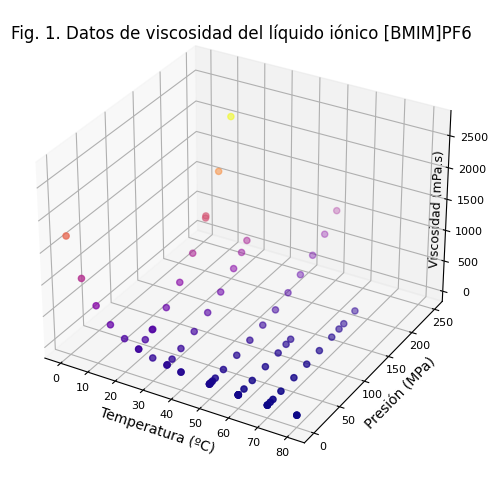

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def graficar_datos_exp_viscosidad_3D(titulo: str):
    # Creando figura
    fig = plt.figure(figsize=(14, 6))           # (ancho, alto),
    ax = fig.add_subplot(111, projection='3d')
    # Titulo
    ax.set_title(titulo, fontsize=12, y=0.999, horizontalalignment='center')
    #ax.titlelocation('center')
    # Asociando variables --> ejes
    x = df['T_C']
    y = df['P_MPa']
    z = df['viscosidad']
    # Grafico de dispersion con mapa de color por valores de viscosidad
    ax.scatter(x, y, z, c=df['viscosidad'], cmap='plasma')
    # Etiquetas de los ejes + config. de espaciado y fuente
    ax.set_xlabel('Temperatura (ºC)', labelpad=-5, fontsize=10)
    ax.set_ylabel('Presión (MPa)', labelpad=-5, fontsize=10)
    ax.set_zlabel('Viscosidad (mPa.s)', labelpad=-25, fontsize=9)
    # Config. formato de numeración de los ejes (fuente, espaciado)
    ax.xaxis.set_tick_params(labelsize=8, pad=-2.5)
    ax.yaxis.set_tick_params(labelsize=8, pad=-2.5)
    ax.zaxis.set_tick_params(labelsize=8, pad=2.5)
    # Ubicando bordes del gráfico en el lienzo
    plt.subplots_adjust(left=0, right=0.4)
    return ax, fig

titulo = 'Fig. 1. Datos de viscosidad del líquido iónico [BMIM]PF6'
ax_1, fig_1 = graficar_datos_exp_viscosidad_3D(titulo)
plt.show()

El mapa de color aplicado varía según el valor de la viscosidad, desde azul intenso para las menores viscosidades hasta rojo / amarillo para las mayores viscosidades.


## Visualizaciones 2D: buscando un modelo

Podemos representar los datos también en figuras 2D, pero debe mantenerse constante alguna de las 3 variables. Por ejemplo, en un diagrama isobárico (P = ctte), podríamos visualizar mejor la viscosidad en función de la temperatura y evaluar posibles modelos que relacionen dichas variables.

Para consultar las presiones más repetidas en los datos, podemos combinar los métodos `.value_counts()` y `.head()` de la librería `pandas`:

In [8]:
df['P_MPa'].value_counts().head()

P_MPa
0.1     24
10.7     2
75.6     2
25.7     2
50.6     2
Name: count, dtype: int64

De los 73 registros totales del DataFrame, hay 24 asociados a la isóbara P = 0.1 MPa, así que vale la pena graficarla.

Los demás registros están muy dispersos en presiones que tienen sólo 1 o 2 valores: no es suficiente información para representar otras líneas de tendencia isobáricas. Se podrían agrupar presiones cercanas entre sí y simular isóbaras "suavizadas" por interpolación numérica, pero implica una complejidad innecesaria.

Por tanto, graficaremos la isóbara principal "P1" de 0.1 MPa:

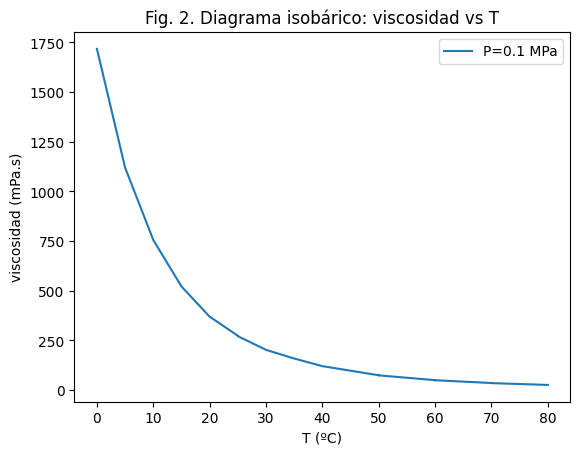

In [9]:
isobara_P1 = df[df['P_MPa'] == 0.1].sort_values(by='T_C')

plt.title('Fig. 2. Diagrama isobárico: viscosidad vs T')
plt.plot(isobara_P1['T_C'],
         isobara_P1['viscosidad'],
         label="P=0.1 MPa")
plt.xlabel('T (ºC)')
plt.ylabel('viscosidad (mPa.s)')
plt.legend()
plt.show()

La línea de tendencia parece una función exponencial decreciente. Como aproximación inicial, nos guiaremos por el modelo de Andrade (ampliamente aceptado para líquidos *covalentes* a _presión constante_):

$$ \ln \mu = A + B / T $$

Donde $\mu$ representa la viscosidad y $T$ la temperatura absoluta (escala Kelvin), mientras que $A$ y $B$ son los parámetros ajustables del modelo (B es positivo). Si el modelo es válido, entonces deberíamos obtener un comportamiento lineal al graficar $ \ln \mu $ vs $ 1/T $.

Para evaluar esta hipótesis, procedemos a calcular los nuevos atributos y luego graficarlos para la isóbara P1.



In [10]:
import numpy as np

df['T_K'] = df['T_C'] + 273.15
# función np.log: logaritmo natural (ln), no el decimal
df['ln_viscosidad'] = np.log(df['viscosidad'])
df['inverso_T_K'] = 1 / df['T_K']
display(df.corr())

,T_C,P_MPa,viscosidad,T_K,ln_viscosidad,inverso_T_K
T_C,1.000000,0.040551,-0.626132,1.000000,-0.797266,-0.997793
P_MPa,0.040551,1.000000,0.477914,0.040551,0.558680,-0.054959
viscosidad,-0.626132,0.477914,1.000000,-0.626132,0.853685,0.634857
T_K,1.000000,0.040551,-0.626132,1.000000,-0.797266,-0.997793
ln_viscosidad,-0.797266,0.558680,0.853685,-0.797266,1.000000,0.792763
inverso_T_K,-0.997793,-0.054959,0.634857,-0.997793,0.792763,1.000000


El índice de correlación de `ln_viscosidad` vs `inverso_T_K` (r = +0.7928) mejoró respecto a `viscosidad` vs `T_K` (r = -0.6261). Parece buena señal, pero falta graficar:

In [11]:
# Como agregamos nuevos atributos al df en la celda anterior,
# debemos cargar nuevamente la isobara_P1
isobara_P1 = df[df['P_MPa'] == 0.1].sort_values(by='T_C')

# Al ordenar el dataFrame, se rompe el indexado inicial
# Buscamos ahora por iloc (indice real) en lugar de loc (index "label")
x1, y1 = isobara_P1.iloc[0][['inverso_T_K', 'ln_viscosidad']]
x2, y2 = isobara_P1.iloc[-1][['inverso_T_K', 'ln_viscosidad']]

# La idea de extraer los puntos (x1, y1); (x2, y2) es graficar una recta
# de referencia para mostrar la no linealidad de la tendencia de los datos

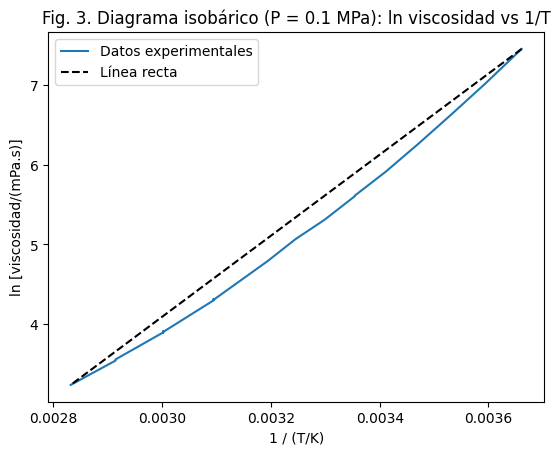

In [12]:
plt.title('Fig. 3. Diagrama isobárico (P = 0.1 MPa): ln viscosidad vs 1/T')
plt.xlabel('1 / (T/K)')
plt.ylabel('ln [viscosidad/(mPa.s)]')

plt.plot(isobara_P1['inverso_T_K'],
         isobara_P1['ln_viscosidad'],
         label="Datos experimentales")
#
plt.plot([x1, x2], [y1, y2], '--k', label="Línea recta")
plt.legend()
plt.show()

La línea de tendencia de los datos experimentales no es recta. ¿Qué pudo salir mal? El modelo de Andrade de 2 parámetros es bueno para líquidos *covalentes*, pero ahora estudiamos un líquido *iónico*: las interacciones son diferentes y afectan a las propiedades físicas. Para líquidos iónicos, se ha propuesto el modelo de 3 parámetros de VFT (Vogel - Fulcher - Tammann):

$$ \ln \mu = A' + B' / (T-T_0) $$

El parámetro adicional `T0` es una temperatura absoluta; por lo tanto, debe ser positivo. Dado que B' es positivo, entonces T0 también debe ser menor que cualquier valor de T; de lo contrario, el modelo podría predecir viscosidades crecientes respecto a T, lo cual no tiene sentido físico.

Como curiosidad, fíjese que los modelos Andrade y VFT para la viscosidad de líquidos son parecidos a los Clausius-Clapyeron y Antoine para presión de vapor, respectivamente (puede repasarlos en [este artículo](https://colab.research.google.com/drive/16Im-iMjiHDebscpuLSGtJ_SE8ekvoM8X)). Sólo cambia el signo que multiplica al parámetro B: mientras que la presión de vapor aumenta con la temperatura, la viscosidad en cambio disminuye.

Ahora, vamos a graficar isotermas (T constante) de viscosidad en función de la presión. Primero, vamos a consultar las temperaturas más frecuentes en los registros:



In [13]:
df['T_C'].value_counts().head(6)

T_C
50    17
70    13
25    12
60    11
35    10
40     2
Name: count, dtype: int64

Las isotermas de 25 ºC, 35 ºC, 50 ºC, 60 ºC y 70 ºC son las que tienen más registros. Las demás temperaturas apenas tienen 1 o 2 registros cada una, así que sólo graficaremos las principales.

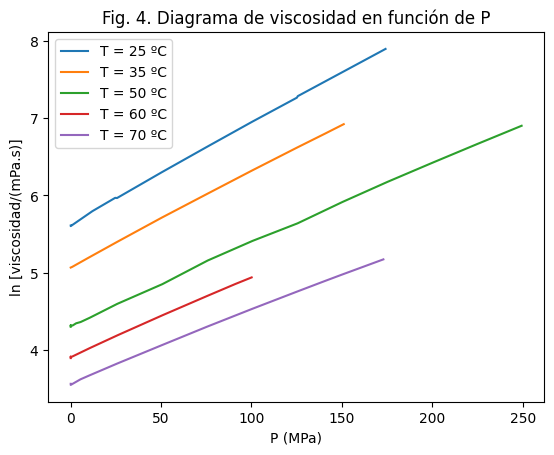

In [14]:
temperaturas_C = [25, 35, 50, 60, 70]

plt.title('Fig. 4. Diagrama de viscosidad en función de P')
for T in temperaturas_C:
    isoterma = df[df['T_C'] == T].sort_values(by='P_MPa')
    plt.plot(isoterma['P_MPa'], isoterma['ln_viscosidad'], label=f"{T = } ºC")
plt.xlabel('P (MPa)')
plt.ylabel('ln [viscosidad/(mPa.s)]')
plt.legend()
plt.show()

Las proyecciones isotermas sugieren una dependencia lineal del logaritmo de la viscosidad respecto a la presión.

Si aplicamos esta dependencia respecto a la presión sobre los parámetros del modelo de VFT, tenemos:

$$ A' = a_0 + a_1P $$
$$ B' = b_0 + b_1P $$

Finalmente, obtenemos un modelo multivariable para la viscosidad:

$$ \ln \mu = (a_0 + a_1P) + (b_0 + b_1P) / (T - T_0) $$


## Train set y test set estratificados

Como paso previo al ajuste del modelo, hay que dividir los datos en los conjuntos de entrenamiento (_train-set_) y prueba (_test-set_).

Mientras que hay muchos datos publicados de viscosidad de líquidos en función de la temperatura, en cambio son más escasos los datos en función de la presión. Por lo tanto, se priorizará esta variable para la estratificación de los datos.

Anteriormente vimos que, de la población total de 73 datos, hay 24 asociados a la presión de 0.1 MPa. En base a esto, vamos a estratificar por 3 *quantiles* de presión: "baja", "media" y "alta", teniendo cada uno 1/3 de los datos. Aplicando la función `qcut()` de `pandas`:

In [15]:
df['rango_presion'], bins = pd.qcut(
    df['P_MPa'],
    q=3,
    labels=['baja', 'media', 'alta'],
    retbins=True,
)

limites_presion_MPa = bins
print(f"{limites_presion_MPa = }")

limites_presion_MPa = array([1.000e-01, 9.000e-01, 7.580e+01, 2.493e+02])


 - 1er quantil: 0.01 - 0.09 MPa
 - 2do quantil: 0.09 - 75.8 MPa
 - 3er quantil: 75.8 - 249.3 MPa

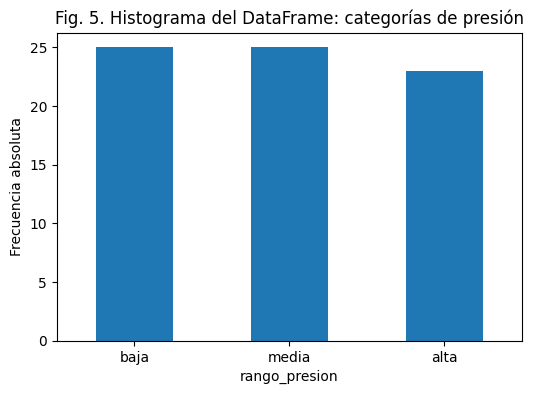

In [16]:
df['rango_presion'].value_counts().plot.bar(figsize=(6, 4), rot=0)
plt.title('Fig. 5. Histograma del DataFrame: categorías de presión')
plt.ylabel('Frecuencia absoluta')
plt.show()

La fig. 5 nos muestra que se cumple aproximadamente la distribución deseada de 3 tercios por rango de presión: 25 valores (baja), 25 valores (media) y 23 valores (alta). Se entiende que no puede ser perfecta la partición, dado que el total de valores (73) no es divisible por 3.

Luego de estratificar el DataFrame completo, creamos ahora los conjuntos train-set y test-set:

In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['rango_presion'])

Comprobamos gráficamente la estratificación:

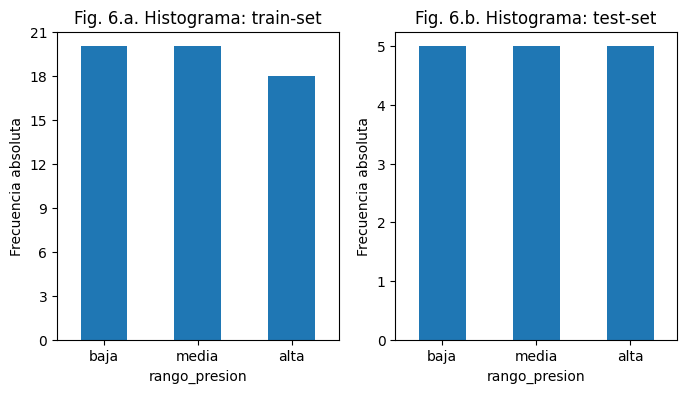

In [18]:
from matplotlib.ticker import MaxNLocator

# Creamos 2 subgráficos en 1 fila para comparar
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Train set
ax1.set_title('Fig. 6.a. Histograma: train-set')
train_frec = train_set['rango_presion'].value_counts().sort_index()
train_frec.plot.bar(ax=ax1, rot=0)

# Test set
ax2.set_title('Fig. 6.b. Histograma: test-set')
test_frec = test_set['rango_presion'].value_counts().sort_index()
test_frec.plot.bar(ax=ax2, rot=0)

# Config. eje vertical
for axes in (ax1, ax2):
    # Eje Y: sólo números enteros
    axes.yaxis.set_major_locator(MaxNLocator(integer=True))
    axes.set_ylabel('Frecuencia absoluta')

plt.show()

Como se puede apreciar, se mantuvo la misma estratificación en ambos conjuntos.

## Función `curve_fit`: problemas multivariados

Antes de continuar con el problema real, vamos a repasar algunas características sobre el ajuste de funciones multivariadas y la función `curve_fit` de la librería `SciPy`.

Como ejemplo más sencillo, vamos a utilizar el siguiente modelo: $ z = ax^2 + bxy + cy $, y sumarle un pequeño ruido aleatorio para generar pseudodatos. Luego, trataremos de ajustar los pseudodatos al modelo original.


In [19]:
from scipy.optimize import curve_fit

import numpy as np

np.random.seed(42)

a, b, c = 2, -1, -2
n_dat = 6
x = np.arange(n_dat)
y = np.arange(n_dat)
z_dat = a*x**2 + b*x*y + c*y + np.random.uniform(-0.1, 0.1, n_dat)

pd.DataFrame({'x': x, 'y': y, 'z_dat': z_dat})

,x,y,z_dat
0,0,0,-0.025092
1,1,1,-0.909857
2,2,2,0.046399
3,3,3,3.019732
4,4,4,7.931204
5,5,5,14.931199


Para ajustar un modelo multivariado, la función `curve_fit` requiere que los datos de las variables independientes estén combinadas en un único array de dimensiones `(k, M)`, donde `k` representa el número de variables independientes y `M` la cantidad de puntos. A su vez, el modelo ajustable debe ser una función que reciba como primer argumento ese mismo arreglo y los demás argumentos corresponden a los parámetros ajustables.

In [20]:
def func_prueba(xy, a, b, c):
    x, y = xy
    return a*x**2 + b*x*y + c*y

params, params_covar = curve_fit(func_prueba, (x, y), z_dat)
a1, b1, c1 = params
print(f"{a1 = }; {b1 = }; {c1 = }")

a1 = -100.90181285132489; b1 = 101.887722148926; c1 = -1.9492117636342359


Nótese que los parámetros obtenidos no coinciden con los esperados (a = 2; b = -1; c = -2). ¿Significa que el método curve_fit falló? No exactamente. Vamos a comprobar si los nuevos parámetros ajustan satisfactoriamente nuestros pseudodatos de `z`.

In [21]:
z_calc = func_prueba((x, y), a1, b1, c1)

pd.DataFrame({'z_dat': z_dat, 'z_calc': z_calc})

,z_dat,z_calc
0,-0.025092,0.000000
1,-0.909857,-0.963302
2,0.046399,0.045214
3,3.019732,3.025548
4,7.931204,7.977702
5,14.931199,14.901674


Los valores calculados de `z` son muy próximos a los "datos" utilizados. ¿Qué nos muestra esto? Cuando trabajamos con modelos multivariados, aumenta el riesgo de "multiplicidad de soluciones": diferentes combinaciones de parámetros producen resultados muy similares. Para manejar esta situación, es importante tener valores iniciales apropiados de los parámetros o acotarlos.

Si ahora restringimos cada parámetro para el intervalo [-3, 3], obtenemos otro resultado:

In [22]:
params, params_covar = curve_fit(
    func_prueba, (x, y), z_dat, bounds=(-3, 3))

a2, b2, c2 = params
z_calc = func_prueba((x, y), a2, b2, c2)

print(f"{a2 = }; {b2 = }; {c2 = }")
pd.DataFrame({'z_dat': z_dat, 'z_calc': z_calc})

a2 = 0.4929489313706078; b2 = 0.4929603662704685; c2 = -1.9492117637921382


,z_dat,z_calc
0,-0.025092,0.000000
1,-0.909857,-0.963302
2,0.046399,0.045214
3,3.019732,3.025548
4,7.931204,7.977702
5,14.931199,14.901674


## Ajuste de parámetros del modelo de viscosidad

Ahora procedemos a ajustar el modelo multivariado para la viscosidad. Repasemos la ecuación:

$$ \ln \mu = (a_0 + a_1P) + (b_0 + b_1P) / (T - T_0) $$

Como se discutió previamente, el parámetro T0 es una temperatura absoluta, así que debe ser positivo. Además, debe ser menor que cualquier temperatura del líquido. Podríamos acotar T0 en el intervalo (100 K, 250 K).

Respecto a los parámetros (a0, a1, b0, b1), no tenemos información suficiente para acotarlos. Para indicarle a `curve_fit` que un parámetro no está acotado, se debe utilizar como "bounds" $ (-∞, +∞) $.


In [23]:
def func_ln_viscos_TP(TP, T0, a0, a1, b0, b1):
    T, P = TP
    return a0 + a1*P + (b0 + b1*P) / (T - T0)

# Transposicion --> metodo `.T`
# Aplicamos esta operacion para obtener dimensiones compatibles con curve_fit
TP_data_train = np.array(train_set[['T_K', 'P_MPa']]).T
TP_data_train.shape
ln_visc_train = train_set['ln_viscosidad']

# Parametros no acotados {a0, a1, b0, b1} --> (-inf, +inf)
cota_min_params = np.array([100] + [-np.inf]*4)
cota_max_params = np.array([250] + [np.inf]*4)

params_ajust, params_covar = curve_fit(
    f=func_ln_viscos_TP,
    xdata=TP_data_train,
    ydata=ln_visc_train,
    bounds=(cota_min_params, cota_max_params)
)

In [24]:
T0, a0, a1, b0, b1 = params_ajust
print(f"{T0 = :.2f} K")
print(f"{a0 = :.4f}")
print(f"{a1 = :.4e} MPa^-1")
print(f"{b0 = :.2f} K")
print(f"{b1 = :.4f} K/MPa")

T0 = 160.89 K
a0 = -2.6880
a1 = -3.1723e-03 MPa^-1
b0 = 1139.35 K
b1 = 2.2559 K/MPa


## Evaluación del modelo en el test-set

Para evaluar el desempeño del modelo, necesitamos en primer lugar calcular las predicciones para el conjunto de datos del test-set. Este conjunto es diferente al que se utilizó para el entrenamiento del modelo. Es importante esta comprobación: no tiene utilidad práctica un modelo que sólo funcione para los datos con los cuales se entrenó, pero que no tenga capacidad predictiva para nuevos datos.

Luego, calibraremos la recta de ajuste para este conjunto, siendo "y" las predicciones del modelo y "x" los datos experimentales. Para un ajuste "ideal", se obtendría una recta identidad: y = x. Observe que esto implica una pendiente = 1 y un intercepto (*bias*) = 0.

Finalmente, graficaremos en una misma figura las predicciones de viscosidad asociadas a cada valor experimental de viscosidad, así como la recta calibrada.

**Nota:** este enfoque puede extenderse a problemas de mayor complejidad, donde una variable "y" dependa de N predictores (x1, x2, ..., xN) y no sea factible graficar en función de los mismos.

In [25]:
# Ordenando por viscosidad ascendente
test_set.sort_values(by='viscosidad', inplace=True)
TP_data_test = np.array(test_set[['T_K', 'P_MPa']]).T
# Logaritmo natural de viscosidad (prediccion)
ln_visc_pred_test = func_ln_viscos_TP(TP_data_test, *params_ajust)
# Viscosidad: prediccion vs datos
visc_pred_test = np.exp(ln_visc_pred_test)
visc_data_test = test_set['viscosidad']

In [26]:
from sklearn.linear_model import LinearRegression

x = visc_data_test.values.reshape(-1, 1)
y = visc_pred_test
# Entrenamiento
modelo_lineal = LinearRegression()
modelo_lineal.fit(x, y)
# Predicción
visc_calib_test = modelo_lineal.predict(x)
# Recta de calibracion: y = mx + b
b = modelo_lineal.intercept_
m = modelo_lineal.coef_[0]
# Coeficiente de determinación de Pearson (R^2):
R2 = modelo_lineal.score(x, y)

print(f"Ec. de la recta de calibración: test-set")
print(f"y = {b :.4f} + {m :.4f}x")
print(f"{R2 = :.4f}")

Ec. de la recta de calibración: test-set
y = -0.4259 + 1.0085x
R2 = 0.9943


Los parámetros de la recta de calibración sugieren un buen desempeño del modelo ajustado.

- R^2 casi 1 ✅
- Pendiente casi 1 ✅
- Bias casi 0 ✅

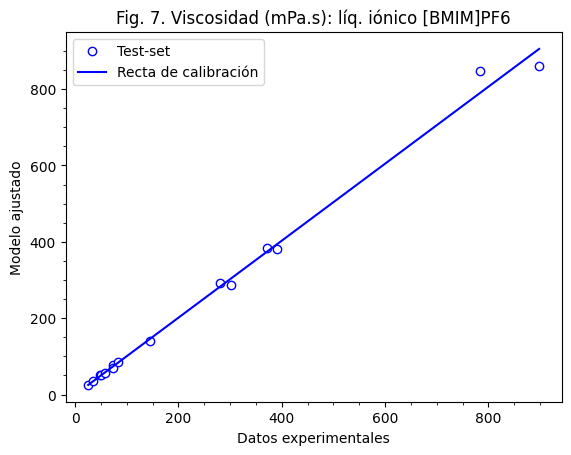

In [27]:
plt.plot(visc_data_test, visc_pred_test, 'o',
         label='Test-set',
         markerfacecolor='white', markeredgecolor='blue')
plt.plot(visc_data_test, visc_calib_test, '-b',
         label='Recta de calibración')
plt.title('Fig. 7. Viscosidad (mPa.s): líq. iónico [BMIM]PF6')
plt.xlabel('Datos experimentales')
plt.ylabel('Modelo ajustado')
plt.minorticks_on()
plt.legend()
plt.show()

## Visualización 3D del modelo

Finalmente, vamos a graficar el modelo de viscosidad ajustado, en función de la temperatura y la presión. Como se está trabajando con 3 dimensiones, el resultado ya no será curva sino una superficie. Como paso previo, hay que crear una malla numérica de T y P sobre la cual se evaluará el modelo.

**Nota:** para problemas de mayor dimensionalidad, este enfoque gráfico ya no puede aplicarse.

In [28]:
# Intervalos de T y P
T_C_rango = np.linspace(0, 80, 81)
P_MPa_rango = np.linspace(0, 250, 251)
# Creando malla
T_C, P = np.meshgrid(T_C_rango, P_MPa_rango)
# Evaluación del modelo
T_K = T_C_rango + 273.15
visc_calc = np.exp(func_ln_viscos_TP((T_K, P), *params_ajust))
# Filtro: viscosidad < 2700 mPa.s (máx. valor experimental: 2694 mPa.s)
visc_filt = np.clip(visc_calc, 0, 2700)

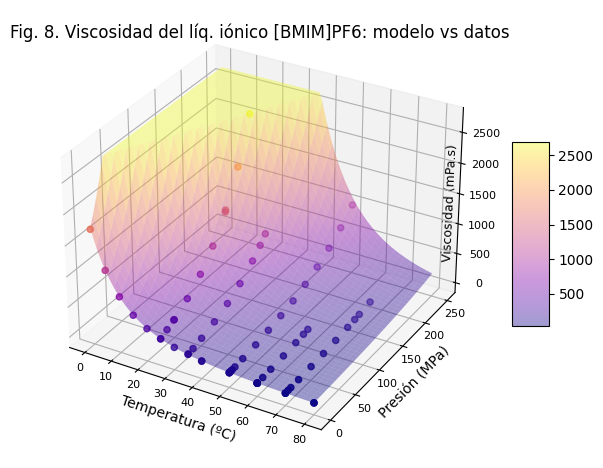

In [29]:
titulo = 'Fig. 8. Viscosidad del líq. iónico [BMIM]PF6: modelo vs datos'
ax, fig = graficar_datos_exp_viscosidad_3D(titulo)
superficie = ax.plot_surface(T_C, P, visc_filt, cmap='plasma', alpha=0.4)
fig.colorbar(superficie, ax=ax, shrink=0.4, aspect=5)
plt.show()

Los datos experimentales están representados como puntos, mientras que la superficie corresponde al modelo. Como se puede apreciar, el ajuste logrado es satisfactorio.

## Conclusiones

1. La librería `pandas` facilita el análisis exploratorio de los datos, etapa inicial necesaria en problemas de Ciencia de Datos.

2. La matriz de correlación es una herramienta útil para detectar las variables más relevantes en problemas complejos.

3. En problemas multivariados, puede ser útil restringir constante una variable para analizar mejor la relación funcional entre las demás.

4. La librería `Matplotlib` permite graficar representaciones 2D y 3D, útiles para una mejor visualización de las tendencias en los datos.

5. La división de los datos en conjuntos de entrenamiento (train-set) y prueba (test-set) mediante un muestreo aleatorio estratificado es un procedimiento necesario antes de ajustar un modelo, y puede implementarse fácilmente con las librerías `pandas` y `SciKit Learn`.

6. La función `curve_fit` de la librería `SciPy` permite ajustar modelos no lineales y multivariables; sin embargo, conviene aplicar criterios lógicos de restricción sobre los parámetros para evitar "soluciones" no deseadas.

7. El ajuste del modelo propuesto de viscosidad en función de presión y temperatura resultó satisfactorio para el líquido iónico [BMIM]PF6.